In [1]:
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
class Word:
    def __init__(self, word: str):
        self._word = word
    def __repr__(self):
        return repr(self._word)
    def H(self):
        return Word(self._word[::-1])
    def __hash__(self):
        return hash(self._word)
    def __eq__(self, other):
        if not isinstance(other, Word):
            return False
        return self._word == other._word

class TraceOp:
    def __init__(self, word: Word):
        self._word = word
        self._expval = cp.Variable(1, str(self._word), complex=True)
    def __hash__(self):
        return hash(self._word)
    def ev(self):
        return self._expval
    def conjev(self):
        return cp.conj(self._expval)
    def __eq__(self, other):
        if not isinstance(other, TraceOp):
            return False
        return self._word == other._word

TOcache = dict()

def trace_op(word: Word|str):
    if isinstance(word, str):
        word = Word(word)
    if word not in TOcache:
        TOcache[word] = TraceOp(word)
    return TOcache[word]

def commutator(word1: str, word2: str):
    expression = []
    for i in range(len(word1)):
        for j in range(len(word2)):
            # 1 2 2 1
            word = word1[:i] + word2[:j] + word2[j+1:] + word1[i+1:]
            if word1[i] == 'x' and word2[j] == 'p':
                expression.append('+' + word)
            elif word1[i] == 'p' and word2[j] == 'x':
                expression.append('-' + word)
    return expression

# def commutator(word1: str, word2: str):
#     expression = []
#     if len(word1) == 1 and len(word2) == 1:
#         if word1 == 'x' and word2 == 'p':
#             expression.append('+')
#         elif word1 == 'p' and word2 == 'x':
#             expression.append('-')
#     elif len(word1) == 1:
#         terms1 = commutator(word1, word2[1:])
#         terms2 = commutator(word1, word2[0])
#         for term in terms1:
#             expression.append(term[0] + word2[0] + term[1:])
#         for term in terms2:
#             expression.append(term[0] + term[1:] + word2[1:])
#     else:
#         terms1 = commutator(word1[1:], word2)
#         terms2 = commutator(word1[0], word2)
#         for term in terms1:
#             expression.append(term[0] + word1[0] + term[1:])
#         for term in terms2:
#             expression.append(term[0] + term[1:] + word1[1:])
#     return expression

In [3]:
def normalization():
    return [trace_op('').ev() == 1]

def moment_matrix(op_basis, L):
    ops = [op
           for i in range(L//2 + 1)
           for op in op_basis[i]]
    n = len(ops)
    M = cp.bmat([[trace_op(ops[i][::-1] + ops[j]).ev() for j in range(n)] for i in range(n)])
    return [M >> 0]

def symmetry_constraint(G: list, word: str):
    return [sum(coeff * trace_op(w + word).ev() for coeff, w in G) == 0]

def schwinger_dyson(hamil: list, word: str):
    expression = 0
    for coeff, w in hamil:
        terms = commutator(w, word)
        for term in terms:
            if term[0] == '+':
                expression = expression + coeff * trace_op(term[1:]).ev()
            else:
                expression = expression - coeff * trace_op(term[1:]).ev()
    return [expression == 0]

def reality(word: str):
    return [trace_op(word[::-1]).ev() == trace_op(word).conjev()]

def trace_cyclicity(word: str):
    word1 = word
    word2 = word[1:] + word[0]
    expression = trace_op(word2).ev()
    for i in range(1, len(word1)):
        if word[0] == 'x' and word[i] == 'p':
            expression = expression + 1j * trace_op(word[1:i]).ev() * trace_op(word[i+1:]).ev()
        elif word[1] == 'p' and word[i] == 'x':
            expression = expression - 1j * trace_op(word[1:i]).ev() * trace_op(word[i+1:]).ev()
    return [trace_op(word1) == expression]

In [16]:
from itertools import product
G = [(1j, 'xp'), (-1j, 'px'), (1, '')]
L = 6
op_basis = [[] for _ in range(L + 1)]
basis = ['x','p']
for l,v in enumerate(op_basis):
    v.extend(''.join(s) for s in product(basis,repeat=l))

In [17]:
constraints = []
constraints.extend(normalization())
constraints.extend(moment_matrix(op_basis, L))
for i in range(L - 1):
    for word in op_basis[i]:
        constraints.extend(symmetry_constraint(G, word))
for i in range(L + 1):
    for word in op_basis[i]:
        constraints.extend(reality(word))

In [14]:
gs = np.linspace(0,4,num=10)
mins = []

for g in gs:
    hamil = [(1, 'pp'), (1, 'xx'), (g, 'xxxx')]
    hamil_constraints = []
    for i in range(L - 1):
        for word in op_basis[i]:
            hamil_constraints.extend(schwinger_dyson(hamil, word))
    total_constraints = constraints + hamil_constraints
    minobj = cp.Minimize(cp.real(sum(coeff * trace_op(w).ev() for coeff, w in hamil)))
    minprob = cp.Problem(minobj, total_constraints)
    print(f'Solving for g={g}:')
    mins.append(minprob.solve(solver=cp.SCS))
    print(f'\tE_min = {mins[-1]}')

Solving for g=0.0:


/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #2 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


	E_min = 1.0010824681787895
Solving for g=0.4444444444444444:
	E_min = 1.2207487463303497
Solving for g=0.8888888888888888:
	E_min = 1.3614961407666963
Solving for g=1.3333333333333333:
	E_min = 1.4714788696747503
Solving for g=1.7777777777777777:
	E_min = 1.570087566447234
Solving for g=2.2222222222222223:
	E_min = 1.6465479760574824
Solving for g=2.6666666666666665:
	E_min = 1.7110697475478465
Solving for g=3.1111111111111107:
	E_min = 1.7760548464686237
Solving for g=3.5555555555555554:
	E_min = 1.8367604568067295
Solving for g=4.0:
	E_min = 1.8917438589564992


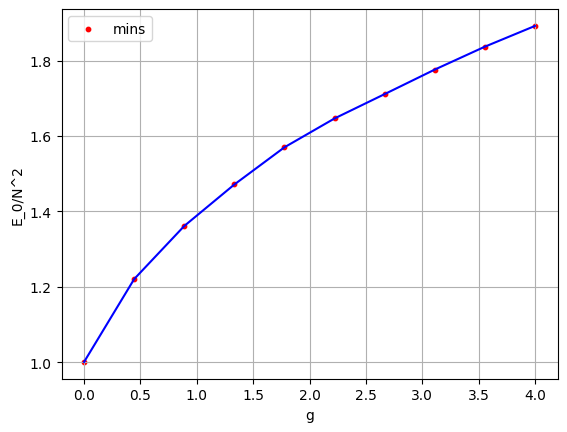

In [15]:
plt.plot(gs, mins, c='blue')
plt.scatter(gs, mins, c='red', s=10, label='mins')
plt.xlabel('g')
plt.ylabel('E_0/N^2')
plt.legend()
plt.grid()
plt.show()

In [18]:
gs = np.linspace(0,4,num=10)
mins = []

for g in gs:
    hamil = [(1, 'pp'), (1, 'xx'), (g, 'xxxx')]
    hamil_constraints = []
    for i in range(L - 1):
        for word in op_basis[i]:
            hamil_constraints.extend(schwinger_dyson(hamil, word))
    total_constraints = constraints + hamil_constraints
    minobj = cp.Minimize(cp.real(sum(coeff * trace_op(w).ev() for coeff, w in hamil)))
    minprob = cp.Problem(minobj, total_constraints)
    print(f'Solving for g={g}:')
    mins.append(minprob.solve(solver=cp.SCS))
    print(f'\tE_min = {mins[-1]}')

Solving for g=0.0:
	E_min = 1.0000031214029108
Solving for g=0.4444444444444444:
	E_min = 1.095449909028415
Solving for g=0.8888888888888888:
	E_min = 1.1701717214724843
Solving for g=1.3333333333333333:
	E_min = 1.2370431672274969
Solving for g=1.7777777777777777:
	E_min = 1.2912449921437061
Solving for g=2.2222222222222223:
	E_min = 1.3407362147186836
Solving for g=2.6666666666666665:


/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


	E_min = 1.3747967836817379
Solving for g=3.1111111111111107:
	E_min = 1.4190188443124323
Solving for g=3.5555555555555554:
	E_min = 1.4587292876467
Solving for g=4.0:
	E_min = 1.4958826967702472


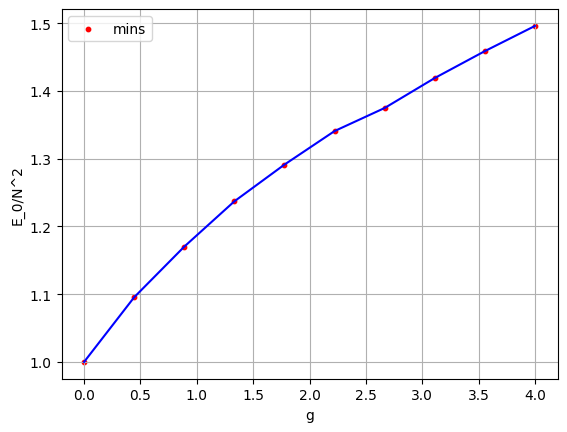

In [19]:
plt.plot(gs, mins, c='blue')
plt.scatter(gs, mins, c='red', s=10, label='mins')
plt.xlabel('g')
plt.ylabel('E_0/N^2')
plt.legend()
plt.grid()
plt.show()